# Data Preprocessing: Text

This notebook focuses on the text preprocessing steps for the model development. The objective is to extract and categorize contextual information from the raw `masterlist.csv` and `categories.csv`, which contain manually copy-pasted text from the sourcebook.

### Required Modules

In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

In [2]:
masterlist = pd.read_csv('data/external/source-ik/masterlist.csv')
masterlist = masterlist[['filename','instruction']]
masterlist.head(3)

,filename,instruction
0,beginner-1-pole-toe-walk,maintain feet plantar flexed throughout the ex...
1,beginner-2-step-around-1-pivot,start with a pole walk and maintain feet plant...
2,beginner-2-step-around-2-sit,start with a pole walk and maintain feet plant...


In [3]:
categories = pd.read_csv('data/external/source-ik/categories.csv')
categories.head(3)

,grip_type,leg_type,aerial,floorwork,upper_region,middle_region,lower_region
0,armpit grip,straddle,aerial,floorwork,arm,abdomen,adductor
1,baseball grip,crossed,climb,prone,arms,abdominal,adductors
2,forearm grip,scissors,aerial,supine,armpit,abdominals,ankle


## Extracting and Categorizing Contextual Information

### Categories and Pose Names

We define a regular expression pattern `r"(?P<category>\w+)-\d+-(?P<pole_name>.+)"`. This pattern is designed to capture two groups from the 'filename' strings: category and pose names.

In [4]:
df = masterlist.copy()
df = df[['filename','instruction']]

pattern = r"(?P<category>\w+)-\d+-(?P<pole_name>.+)"
df[['category', 'name']] = df['filename'].str.extract(pattern)
df['name'] = df['name'].str.replace('-', ' ', regex=False)

df

,filename,instruction,category,name
0,beginner-1-pole-toe-walk,maintain feet plantar flexed throughout the ex...,beginner,pole toe walk
1,beginner-2-step-around-1-pivot,start with a pole walk and maintain feet plant...,beginner,step around 1 pivot
2,beginner-2-step-around-2-sit,start with a pole walk and maintain feet plant...,beginner,step around 2 sit
3,beginner-2-step-around-3-leg-up,start with a pole walk and maintain feet plant...,beginner,step around 3 leg up
4,beginner-3-bridge,maintain feet plantar flexed throughout the ex...,beginner,bridge
...,...,...,...,...
566,workout-48-shoulder-mount-open-v-2,comfortably support the shoulder (trapezius) o...,workout,shoulder mount open v 2
567,workout-49-iguana-press,assume a layback crossed-ankle position. maint...,workout,iguana press
568,workout-50-inverted-push-ups,assume a layback crossed-ankle position. maint...,workout,inverted push ups
569,workout-43-one-handed-handstand,assume a layback crossed-ankle position. maint...,workout,one handed handstand


### Identifying Aerial or Grounded

From the previous notebook, we discovered that more information is needed to identify spatial orientation. Therefore, we need to add a new column for aerial or grounded.

1. **Application of Logical Reasoning**: We start by examining the given categories from the sourcebook. Using logical reasoning, we identify and classify elements as either related to aerial or floorwork based on their inherent characteristics and the nature of the movements they involve.

2. **Elimination and Keyword Search**: After classifying the clear cases, we remove all elements that have already been definitively labeled. For the remaining, unlabelled elements, we conduct a detailed keyword search. This search helps us find specific terms or phrases within the textual content that can indicate whether an element is associated with aerial or floorwork, thus completing the labeling process.

In [5]:
categories_sourcebook = df['category'].unique().tolist()
print("unique categories from sourcebook:", categories_sourcebook)

categories_aerial =  categories['aerial'].unique()
categories_aerial =  categories['aerial'].dropna().tolist()
print("keywords suggesting aerial:", categories_aerial)

categories_floorwork =  categories['floorwork'].unique()
categories_floorwork =  categories['floorwork'].dropna().tolist()
print("keywords suggesting floor:", categories_floorwork)

unique categories from sourcebook: ['beginner', 'intermediate', 'advanced', 'trans', 'grip', 'leg', 'climb', 'shoulder', 'handstand', 'barre', 'stretch', 'workout']
keywords suggesting aerial: ['aerial', 'climb', 'aerial', 'lift', 'invert', 'inverted', 'shoulder mount', 'hang']
keywords suggesting floor: ['floorwork', 'prone', 'supine', 'seat', 'seating', 'seated', 'kneel', 'kneeling', 'kneeled', 'grounded', 'handstand', 'grounded', 'stretch', 'trans', 'grip', 'supine', 'prone']


In [6]:
df2 = df.copy()

aerial_score = []

def keyword_search(instruction, filename, keywords):
    combined_text = instruction.lower() + ' ' + filename.lower()
    return any(keyword in combined_text for keyword in keywords)

for index, row in df2.iterrows():
    if row['category'] in ['trans','grip','handstand','barre','stretch']:
        aerial_score.append(False)
    elif row['category'] in ['leg','climb','shoulder','beginner','intermediate','advanced']:
        aerial_score.append(True)    
    else:
        search = keyword_search(row['instruction'], row['filename'], categories_aerial)
        if search:
            aerial_score.append(True)
        else:
            search2 = keyword_search(row['instruction'], row['filename'], categories_floorwork)
            if search2:
                aerial_score.append(False)
            else:
                aerial_score.append(None)
                
df2['aerial'] = aerial_score
df2[350:360]

,filename,instruction,category,name,aerial
350,grip-14-one-hand-down-baseball-grip,with the body positioned sideways to the pole ...,grip,one hand down baseball grip,False
351,grip-15-two-handed-twisted-grip,"with the body positioned sideways to the pole,...",grip,two handed twisted grip,False
352,grip-16-two-handed-flag-grip,with the body positioned sideways to the pole ...,grip,two handed flag grip,False
353,grip-17-one-hand-twisted-grip,"with the body facing away from the pole, the f...",grip,one hand twisted grip,False
354,grip-18-two-handed-reverse-grab,"with the body facing away from pole, one arm e...",grip,two handed reverse grab,False
355,grip-19-two-handed-half-inverted-grip,with the upper body positioned sideways to the...,grip,two handed half inverted grip,False
356,grip-20-two-handed-iguana-grip,"with the body facing the pole, the head invert...",grip,two handed iguana grip,False
357,grip-21-one-hand-bridge-arch,with the body arched out and facing away from ...,grip,one hand bridge arch,False
358,grip-22-one-hand-cup-grip,with the body facing away and supported by the...,grip,one hand cup grip,False
359,grip-23-two-handed-double-bridge-arch,with the body arched out and facing away from ...,grip,two handed double bridge arch,False


### Pose Engagement Information from Specified Keywords

Pole sport extensively involves stability and control, flexibility, and posture. Therefore, it is important to extract these topics from instructions. In the code below, we have executed the following steps:

1. **Text Splitting by Sentence**: This function divides a given text into sentences, utilizing regular expressions to identify sentence terminators such as periods, exclamation marks, or question marks.
2. **Extracting the First Sentence**: Extracting the first sentence from an instruction often reveals prerequisites in terms of position, which may be valuable for understanding the requirements.
3. **Finding Sentences Containing Keywords**: This function segments the text into sentences and searches each one for specified keywords. It returns the first sentence containing any of the keywords. For our model, we specifically extract information about the pose's stability and flexibility efforts.
4. **Identification of Body Parts**: Based on the extracted sentences, we identify body parts mentioned and include them in a new frame.

In [7]:
def split_text_by_sentence(text):
    sentences = re.split(r'(?<=[.!?]) +', text)
    return sentences

def extract_first_sentence(text):
    sentences = split_text_by_sentence(text)
    return sentences[0] if sentences else None

def find_sentence_containing_keyword(text, keywords):
    sentences = split_text_by_sentence(text)
    for sentence in sentences:
        if any(keyword in sentence for keyword in keywords):
            return sentence
    return None

def categorize_instruction(instruction, body_parts):
    # Check if body_parts is not None and is iterable
    if body_parts and instruction:
        found_parts = set(part for part in body_parts if part in instruction.lower())
        return ', '.join(found_parts) if found_parts else None
    else:
        return None

In [22]:
df3 = df2.copy()

# Keywords by Category
upper_region_keywords = categories['upper_region'].dropna().tolist()
middle_region_keywords = categories['middle_region'].dropna().tolist()
lower_region_keywords = categories['lower_region'].dropna().tolist()
all_regions_keywords = upper_region_keywords + middle_region_keywords + lower_region_keywords

flexibility_keywords = ['required','require', 'flexibility','contortion','contort','arch','arched','front split','front splits',
                       'straddle split','straddle splits']

stability_keywords = ['stabilize', 'stability','control','maintain','contract','contracted']

# Extract Sentences with Context
df3['first_sentence'] = df3['instruction'].apply(extract_first_sentence)
df3['flexibility'] = df3.apply(lambda row: find_sentence_containing_keyword(row['instruction'], flexibility_keywords), axis=1)
df3['stability'] = df3.apply(lambda row: find_sentence_containing_keyword(row['instruction'], stability_keywords), axis=1)

# Extract Regions Found
df3['first_sentence_regions'] = df3['first_sentence'].apply(lambda instruction: categorize_instruction(instruction, all_regions_keywords))
df3['flexibility_regions'] = df3['flexibility'].apply(lambda instruction: categorize_instruction(instruction, all_regions_keywords))
df3['stability_regions'] = df3['stability'].apply(lambda instruction: categorize_instruction(instruction, all_regions_keywords))

In [23]:
df3.head(5)

,filename,instruction,category,name,aerial,first_sentence,flexibility,stability,first_sentence_regions,flexibility_regions,stability_regions
0,beginner-1-pole-toe-walk,maintain feet plantar flexed throughout the ex...,beginner,pole toe walk,True,maintain feet plantar flexed throughout the ex...,None,maintain feet plantar flexed throughout the ex...,"feet plantar, feet, shoulder",None,"feet plantar, feet, shoulder"
1,beginner-2-step-around-1-pivot,start with a pole walk and maintain feet plant...,beginner,step around 1 pivot,True,start with a pole walk and maintain feet plant...,None,start with a pole walk and maintain feet plant...,"feet plantar, feet",None,"feet plantar, feet"
2,beginner-2-step-around-2-sit,start with a pole walk and maintain feet plant...,beginner,step around 2 sit,True,start with a pole walk and maintain feet plant...,None,start with a pole walk and maintain feet plant...,"feet plantar, feet",None,"feet plantar, feet"
3,beginner-2-step-around-3-leg-up,start with a pole walk and maintain feet plant...,beginner,step around 3 leg up,True,start with a pole walk and maintain feet plant...,None,start with a pole walk and maintain feet plant...,"feet plantar, feet",None,"feet plantar, feet"
4,beginner-3-bridge,maintain feet plantar flexed throughout the ex...,beginner,bridge,True,maintain feet plantar flexed throughout the ex...,back flexibility is required.,maintain feet plantar flexed throughout the ex...,"feet plantar, feet",None,"feet plantar, feet"


### Pose Engagement Information based on Anatomy

The code aims to categorize the instructions in pole sport based on the engagement of upper, middle, and lower body regions. The process similarly follows the procedures for extracting pose engagement information.

In [24]:
df4 = df3.copy()

df4['upper_region'] = df4['instruction'].apply(lambda instruction: categorize_instruction(instruction, upper_region_keywords))
df4['middle_region'] = df4['instruction'].apply(lambda instruction: categorize_instruction(instruction, middle_region_keywords))
df4['lower_region'] = df4['instruction'].apply(lambda instruction: categorize_instruction(instruction, lower_region_keywords))

df4.head(3)

,filename,instruction,category,name,aerial,first_sentence,flexibility,stability,first_sentence_regions,flexibility_regions,stability_regions,upper_region,middle_region,lower_region
0,beginner-1-pole-toe-walk,maintain feet plantar flexed throughout the ex...,beginner,pole toe walk,True,maintain feet plantar flexed throughout the ex...,None,maintain feet plantar flexed throughout the ex...,"feet plantar, feet, shoulder",None,"feet plantar, feet, shoulder","hand, shoulder",None,"feet plantar, leg, toes, feet, toe, knees"
1,beginner-2-step-around-1-pivot,start with a pole walk and maintain feet plant...,beginner,step around 1 pivot,True,start with a pole walk and maintain feet plant...,None,start with a pole walk and maintain feet plant...,"feet plantar, feet",None,"feet plantar, feet","hand, shoulder",None,"leg, feet plantar, feet, foot"
2,beginner-2-step-around-2-sit,start with a pole walk and maintain feet plant...,beginner,step around 2 sit,True,start with a pole walk and maintain feet plant...,None,start with a pole walk and maintain feet plant...,"feet plantar, feet",None,"feet plantar, feet","hand, shoulder",None,"leg, feet plantar, feet, foot"


## Qualitative Assessment of Preprocessed Text

1. First, we will summarize the findings, and export the information,
2. Manually check with the image provided and compare the two csv files.

In [34]:
df4.to_csv('data/interim/source-ik/masterlist_processed.csv', index=False)

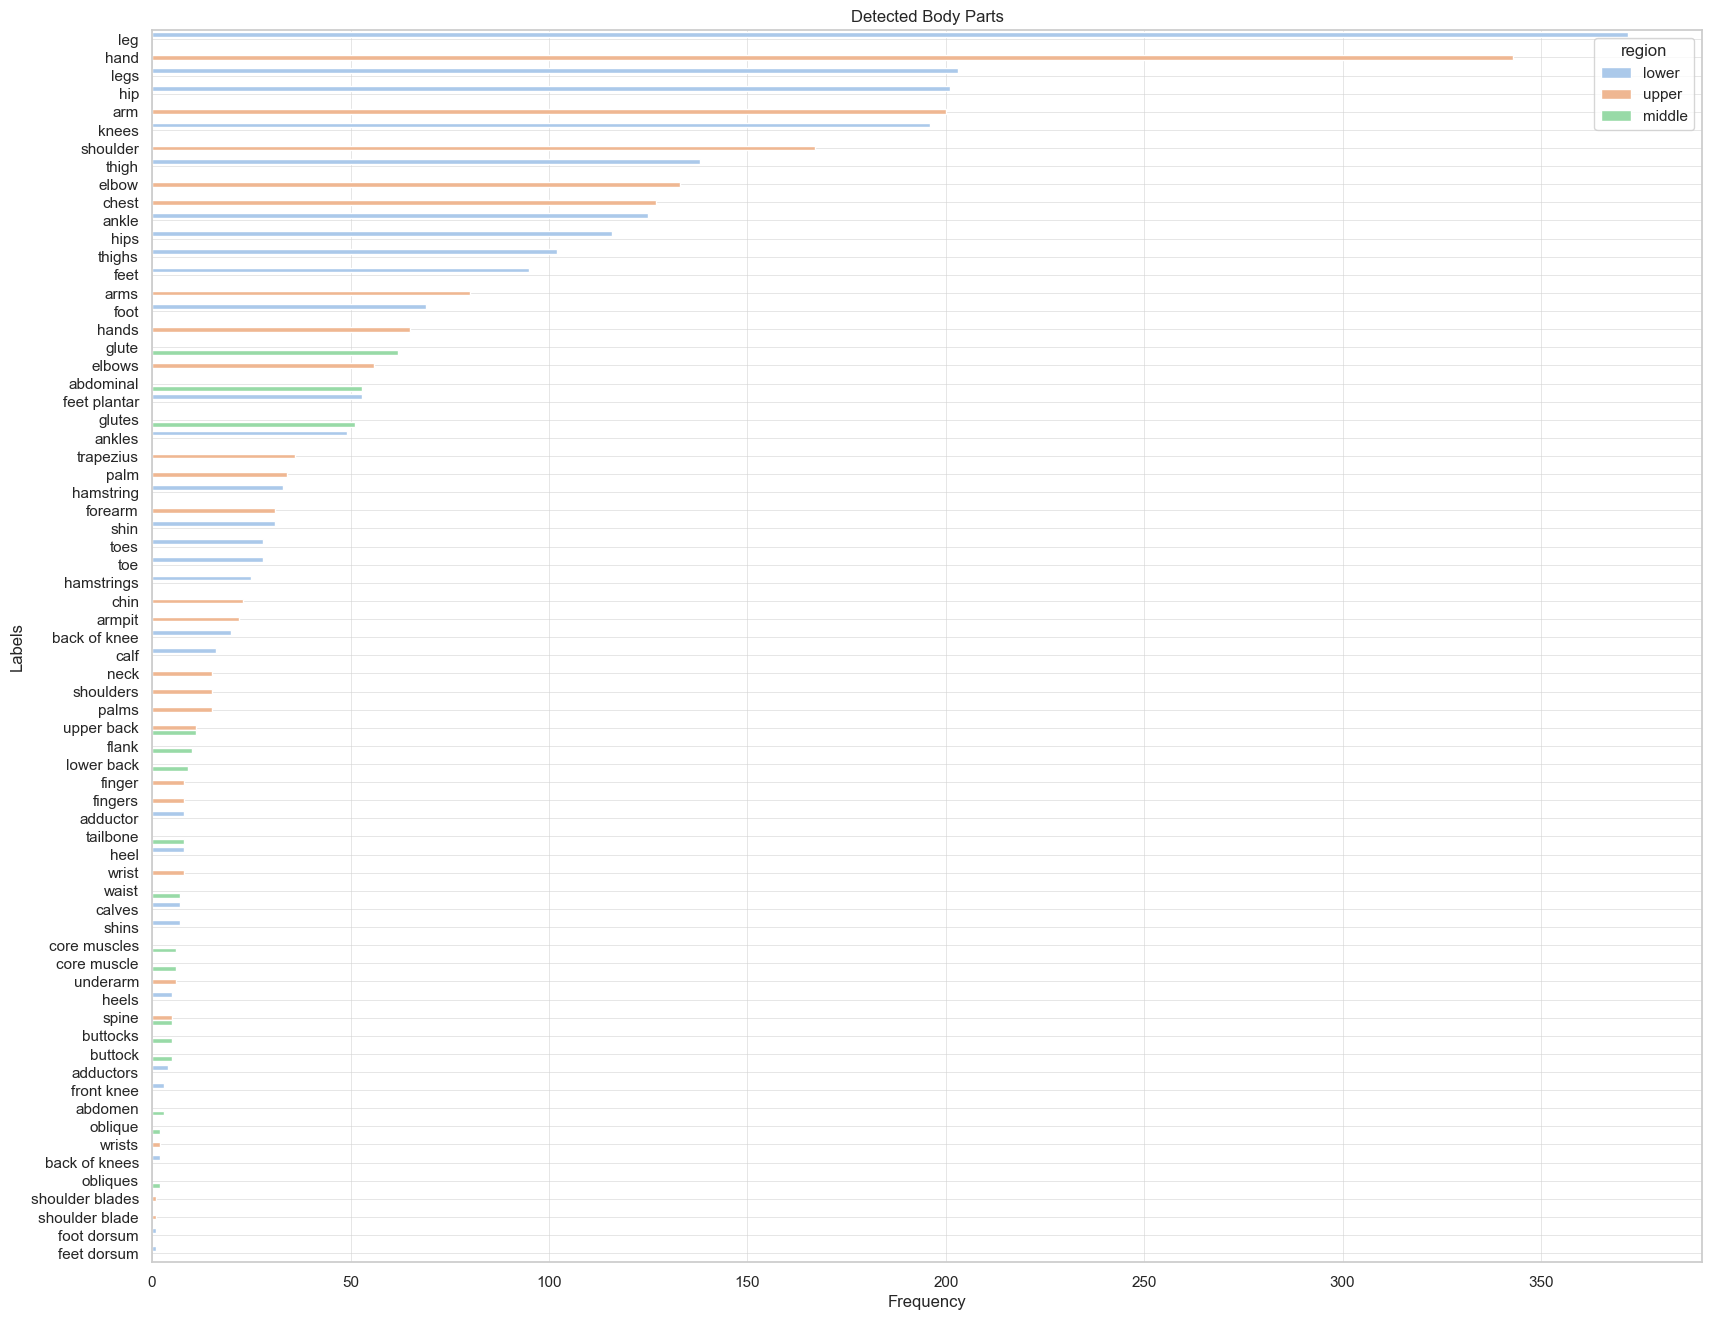

In [32]:
split_upper_region_words = df4['upper_region'].dropna().apply(lambda x: x.split(', ')).sum()
upper_region_counts = Counter(word for word in split_upper_region_words if word in upper_region_keywords)
split_middle_region_words = df4['middle_region'].dropna().apply(lambda x: x.split(', ')).sum()
middle_region_counts = Counter(word for word in split_middle_region_words if word in middle_region_keywords)
split_lower_region_words = df4['lower_region'].dropna().apply(lambda x: x.split(', ')).sum()
lower_region_counts = Counter(word for word in split_lower_region_words if word in lower_region_keywords)

upper_region_df = pd.DataFrame(list(upper_region_counts.items()), columns=['label', 'frequency']).assign(region='upper')
middle_region_df = pd.DataFrame(list(middle_region_counts.items()), columns=['label', 'frequency']).assign(region='middle')
lower_region_df = pd.DataFrame(list(lower_region_counts.items()), columns=['label', 'frequency']).assign(region='lower')

combined_data = pd.concat([upper_region_df, middle_region_df, lower_region_df]).reset_index(drop=True)
sorted_combined_data = combined_data.sort_values(by='frequency', ascending=False)

sns.set_theme(style="whitegrid", palette="pastel")
plt.figure(figsize=(20, 16))
sns.barplot(data=sorted_combined_data, x='frequency', y='label', hue='region')
plt.title('Detected Body Parts')
plt.xlabel('Frequency')
plt.ylabel('Labels')
plt.grid(color='lightgray', linestyle='-', linewidth=0.4)
plt.show()

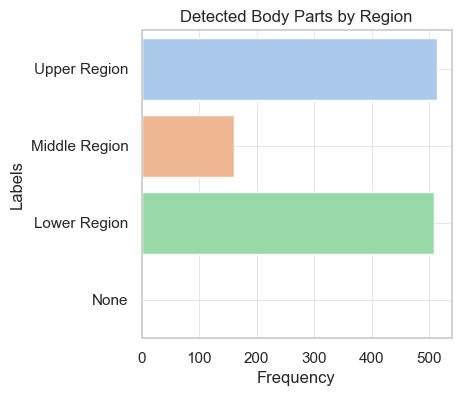

In [28]:
region_counts_dict = {'region': ['Upper Region', 'Middle Region', 'Lower Region', 'None'],
                      'count': [df4['upper_region'].notnull().sum(), 
                                df4['middle_region'].notnull().sum(), 
                                df4['lower_region'].notnull().sum(),
                                df4[['upper_region', 'middle_region', 'lower_region']].isnull().all(axis=1).sum()]}

region_counts = pd.DataFrame(data=region_counts_dict)

sns.set_theme(style="whitegrid", palette="pastel")
plt.figure(figsize=(4, 4))
sns.barplot(data=region_counts, x='count', y='region', hue='region')
plt.title('Detected Body Parts by Region')
plt.xlabel('Frequency')
plt.ylabel('Labels')
plt.grid(color='lightgray', linestyle='-', linewidth=0.4)
plt.show()

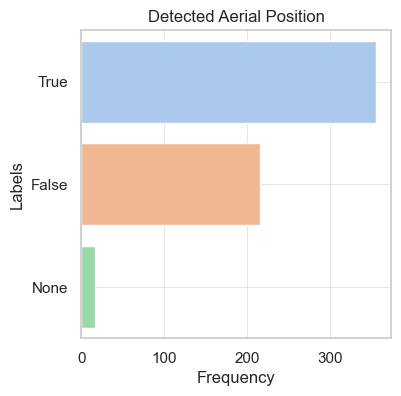

In [29]:
aerial_counts_dict = {'aerial': ['True', 'False', 'None'],
                      'count': [df4['aerial'].sum(), 
                                len(df4) - df4['aerial'].sum(),
                                df4['aerial'].isnull().sum()]}

aerial_counts = pd.DataFrame(data=aerial_counts_dict)

sns.set_theme(style="whitegrid", palette="pastel")
plt.figure(figsize=(4, 4))
sns.barplot(data=aerial_counts, x='count', y='aerial', hue='aerial')
plt.title('Detected Aerial Position')
plt.xlabel('Frequency')
plt.ylabel('Labels')
plt.grid(color='lightgray', linestyle='-', linewidth=0.4)
plt.show()

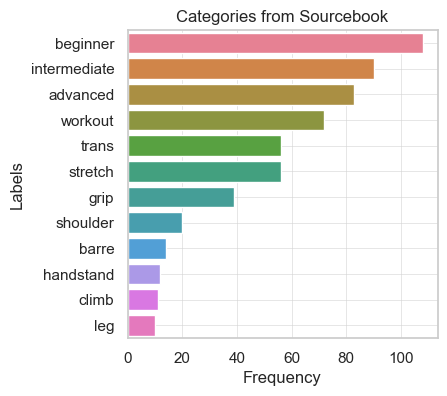

In [31]:
category_counts = df4['category'].value_counts().reset_index()
category_counts.columns = ['category', 'count']

sns.set_theme(style="whitegrid", palette="pastel")
plt.figure(figsize=(4, 4))
sns.barplot(data=category_counts, x='count', y='category', hue='category')
plt.title('Categories from Sourcebook')
plt.xlabel('Frequency')
plt.ylabel('Labels')
plt.grid(color='lightgray', linestyle='-', linewidth=0.4)
plt.show()

## References

* https://www.goodreads.com/book/show/43151907-pole-dance-fitness